#### 패키지 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

#### 전역변수 설정

In [2]:
trainGraphTitle = "Train Data"
testGraphTitle = "Test Data"
loss = "mse" # mse

resultComment = "Activation - sigmoid"
fileSavePath = "./result/Activation/sigmoid"

depth = "SingleGRU" # Default
# depth = "DoubleGRU" 
# depth = "TripleGRU"

# 변수 "" 가 Default
hiddenState = 32 # units: 16 "32" 64
timeStep = 20 # input_length 10 "20" 40
activation = "tanh" # "tanh" sigmoid
epochs = 100 # 50 "100" 200
batchSize = 32 # 32 "64" 256
dataSetYear = 10 # 5 "10" 40
optimizer = "adam" # "adam" sgd

#### Pandas Setting

In [3]:
pd.set_option('display.max_rows', None) # row 생략 없이 출력
pd.set_option('display.max_columns', None) # col 생략 없이 출력

#### Data Load

In [4]:
apple = pd.read_csv("Apple_5Y.csv")

if dataSetYear == 10:
    apple = pd.read_csv("Apple_10Y.csv")
elif dataSetYear == 40:
    apple = pd.read_csv("Apple_Whole_Period.csv")

#### Describe 확인

In [5]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,62.383387,63.087693,61.696664,62.416599,60.637030,1.713540e+08
std,48.683035,49.322128,48.051043,48.709794,49.248659,1.250498e+08
min,13.856071,14.271429,13.753571,13.947500,12.064585,3.519590e+07
25%,26.971249,27.219376,26.705000,26.983750,24.676634,9.188698e+07
50%,41.353750,41.872500,40.888750,41.313750,39.511671,1.301368e+08
75%,91.272499,92.881876,90.824377,91.526875,90.122925,2.045116e+08
max,182.630005,182.940002,179.119995,182.009995,180.959732,1.460852e+09


#### trainData, testData 가공하는 함수

In [6]:
def transformData(data: [[float]]):
    # 날짜 제외
    data = data.drop(columns=["Date"])

    # 데이터 분리 test: 200개와 나머지
    trainSet = data[ : -200]
    testSet = data[-200 : ]
    
    # 데이터 0~1로 정규화
    sc = MinMaxScaler(feature_range=(0, 1)) 
    sc.fit(trainSet)
    trainSet = sc.transform(trainSet)
    testSet = sc.transform(testSet)
    
    # trainX, trainY, testX, testY 분리
    def parsingData(dataSet: [[float]]) -> ([[[float]]], [[float]]):
        dataX, dataY = [], []
        for index in range(len(dataSet) - timeStep):
            temp = []
            for step in range(timeStep):
                temp.append(dataSet[index + step])
            dataX.append(temp)
            dataY.append(dataSet[index + timeStep])

        return np.array(dataX), np.array(dataY)

    trainDataX, trainDataY = parsingData(trainSet)
    testDataX, testDataY = parsingData(testSet)
    
    
    return trainDataX, trainDataY, testDataX[:-30], testDataY, sc

#### Data Parsing

In [7]:
trainX, trainY, testX, testY, scaler = transformData(apple)

#### Model Implementation

In [8]:
model = Sequential()

if depth == "TripleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
    
elif depth == "DoubleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
elif depth == "SingleGRU":
    model.add(
    GRU(
        units = hiddenState,
        input_length = trainX.shape[1],
        input_dim = trainX.shape[2],
        activation = activation
        )
    )
    model.add(Dense(6))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3840      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 4,038
Trainable params: 4,038
Non-trainable params: 0
_________________________________________________________________


2023-01-05 10:33:09.476500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 10:33:09.476602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Model Complie

In [9]:
model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = ["mae"]
)

#### Model Training

In [10]:
earlyStop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1)

fitStartTime = time.time()
history = model.fit(
    trainX,
    trainY,
    epochs = epochs,
    batch_size = batchSize,
    callbacks=[earlyStop]
)
fitEndTime = time.time()

Epoch 1/100


2023-01-05 10:33:09.683946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 10:33:10.288510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 10:33:10.381941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/72 [=>............................] - ETA: 0s - loss: 0.1202 - mae: 0.2206  

2023-01-05 10:33:10.494227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 2s 12ms/step - loss: 0.0278 - mae: 0.0899
Epoch 2/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0015 - mae: 0.0260
Epoch 3/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0011 - mae: 0.0206
Epoch 4/100
72/72 [==============================] - 1s 11ms/step - loss: 8.3216e-04 - mae: 0.0176
Epoch 5/100
72/72 [==============================] - 1s 11ms/step - loss: 7.0396e-04 - mae: 0.0157
Epoch 6/100
72/72 [==============================] - 1s 11ms/step - loss: 6.2081e-04 - mae: 0.0138
Epoch 7/100
72/72 [==============================] - 1s 11ms/step - loss: 5.8280e-04 - mae: 0.0128
Epoch 8/100
72/72 [==============================] - 1s 12ms/step - loss: 5.7275e-04 - mae: 0.0123
Epoch 9/100
72/72 [==============================] - 1s 11ms/step - loss: 5.6242e-04 - mae: 0.0121
Epoch 10/100
72/72 [==============================] - 1s 11ms/step - loss: 5.4591e-04 - mae: 0.0117
Epoch 11/100
72/72 [=============

#### 시간 및 평가 기록

In [11]:
fitTime = fitEndTime - fitStartTime
score = model.evaluate(testX, testY[:-30])

f = open("result.txt", "a")
f.write(f"{resultComment}\n모델 학습 시간: {fitTime:.3} sec\n평가 손실: {score[0]}\n\n")
f.close()

5/5 [==============================] - 0s 16ms/step - loss: 8.8073e-04 - mae: 0.0236


2023-01-05 10:33:24.143940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 10:33:24.177520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
f"모델 학습 시간: {fitTime:.3} sec"

'모델 학습 시간: 14.3 sec'

In [13]:
f"평가 손실: {score[0]}"

'평가 손실: 0.000880726205650717'

#### 예측

In [14]:
trainPrediction = scaler.inverse_transform(model.predict(trainX))
testPrediction = scaler.inverse_transform(model.predict(testX))

inversingTrainY = scaler.inverse_transform(trainY)
inversingTestY = scaler.inverse_transform(testY)

23/72 [========>.....................] - ETA: 0s

2023-01-05 10:33:24.438779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 10:33:24.467727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 12ms/step


### 그래프

#### Loss

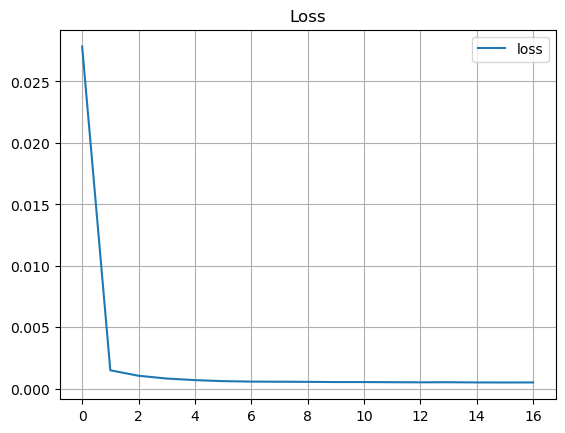

In [15]:
loss = history.history["loss"]
plt.title("Loss")
plt.plot(loss, label="loss")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Loss.png")
plt.legend()
plt.show()

#### Train Data Graph

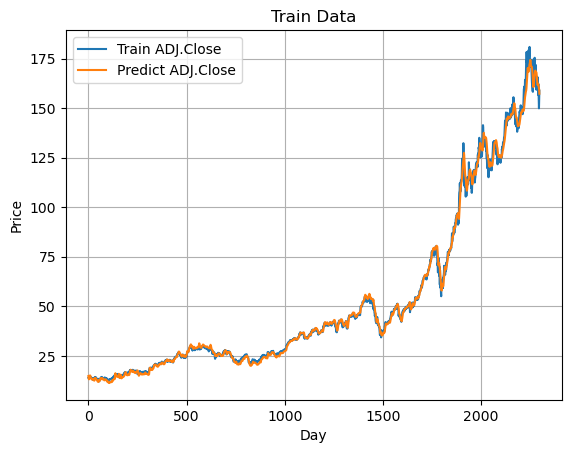

In [16]:
plt.title(trainGraphTitle)
plt.plot(inversingTrainY[:, 4], label="Train ADJ.Close")
plt.plot(trainPrediction[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Train.png")
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Test Data Graph

In [17]:
# plt.title(testGraphTitle)
# plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
# plt.plot(testPrediction[:, 4], label="Predict ADJ.Close")
# plt.grid(True)
# plt.xlabel('Day')
# plt.ylabel('Price')
# plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
# plt.legend()
# plt.savefig(f"{fileSavePath}/Test.png")
# plt.show()

#### Test Data + 30일 후 예측

In [18]:
thirtyPredict = testX

for _ in range(30):
    currentPredict = model.predict(thirtyPredict)
    recentPredict = np.reshape(currentPredict[-1], (1, currentPredict[-1].shape[0]))
    newPredictStep = thirtyPredict[-1, 1:]
    nextPredict = np.append(newPredictStep, recentPredict, axis = 0)
    nextPredict = np.reshape(nextPredict, (1, nextPredict.shape[0], nextPredict.shape[1]))
    thirtyPredict = np.append(thirtyPredict, nextPredict, axis = 0)

6/6 [==============================] - 0s 10ms/step


#### Test Data + 30일 예측 그래프

6/6 [==============================] - 0s 11ms/step


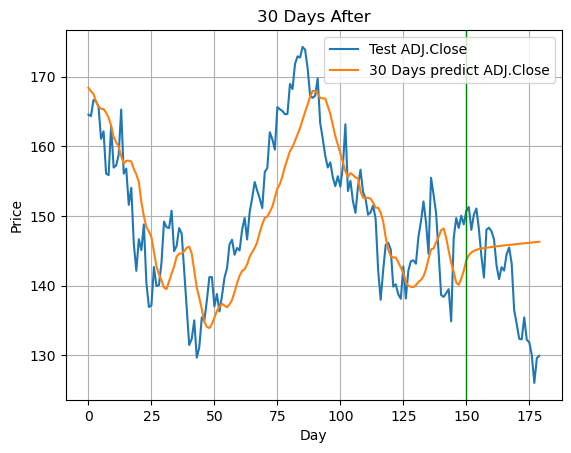

In [19]:
thirtyDaysAfterpredict = scaler.inverse_transform(model.predict(thirtyPredict))

plt.title("30 Days After")
plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
plt.plot(thirtyDaysAfterpredict[:, 4], label="30 Days predict ADJ.Close")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Price')
plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
plt.legend()
plt.savefig(f"{fileSavePath}/30Predict.png")
plt.show()